#FINAL GROUP PROJECT - DATA SYSTEMS ARCHITECTURE - GROUP 2
###Members - Trupal Vijaykumar Chaudhary (200557631), Ashraf Khan (200512871), Sushank Saini (200540699), Amit Malik (200548660)

             




---


The music industry is experiencing rapid growth, with new platforms and technologies emerging each year. Spotify, which was founded in 2006, is currently the most widely used streaming platform globally. We will analyze data from this platform to identify trends in the music industry and provide insights on how singers can increase their popularity, thus enhancing their competitiveness and success.



---





---


'Spotify Charts' from Kaggle, with a 3.48 GB file size, is the dataset that we use.

There are 9 columns, including title, rank, date, artist, url, area, chart, trend, and stream, and there are 26,173,514 observations total. The top 200 Spotify music streamed daily from January 1, 2017, through December 31, 2021, are included in this dataset, which was compiled using the Spotify API.



---


This dataset contains 9 columns, each of which is described below.

*title: the title of the song*

*rank: rank from 1 - 200 (1 being the highest streams)*

*date: date of data*

*artist: name of the artist*

*url: url of the song*

*region: countries around the world*

*chart: top200 or viral50*

*trend: the position of that song on the chart compared to yesterday (MOVE_UP, MOVE_DOWN or SAME_POSITION)*

*streams: the total number of global streams of that song in one day*


---




In [1]:
#import all the libraries

#!pip install pyspark
#!pip install boto3

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
import pyspark.sql.types as t
import pyspark.sql.functions as f

In [2]:
#import csv file of the dataset from the cloud storage - AMAZON S3
import boto3

aws_access_key_id = '' #cannot submit for security purposes
aws_secret_access_key = ''

# Set up the session
session = boto3.Session(
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key
)

# Set up the S3 client
s3 = session.client('s3')
bucket_name = 'dsa-final-project'

s3_object = s3.get_object(Bucket=bucket_name, Key='dataset/charts.csv')
df = pd.read_csv(s3_object['Body'])

In [3]:
print(f"Shape of the DataFrame: {df.shape[0]} rows x {df.shape[1]} columns")

Shape of the DataFrame: 26173514 rows x 9 columns


In [4]:
def visualize_word_counts(counts):
    plt.figure(figsize=(18,15))
    sns.barplot(x=list(counts.values()), y=list(counts.keys()), color='tab:blue')
    plt.title('Word Frequency', fontsize=25)
    plt.xlabel('Count', fontsize=20)
    plt.ylabel('Word', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()


In [5]:
#TOP 10 POPULAR ARTISIS:
counts = df['artist'].value_counts()
counts.head(10)

Ed Sheeran         387917
Billie Eilish      251825
Post Malone        211272
Bad Bunny          203403
Ariana Grande      189914
Dua Lipa           187085
Drake              177380
Imagine Dragons    157900
XXXTENTACION       155458
BTS                154338
Name: artist, dtype: int64

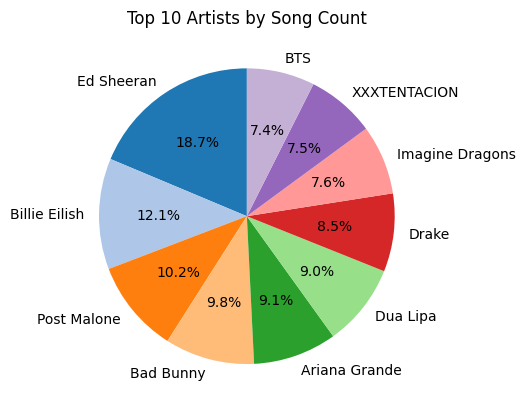

In [6]:
top_artists = counts.head(10)

import os
if not os.path.exists('img'):
    os.makedirs('img')

# Create a pie chart of the artist counts
plt.pie(top_artists.values, labels=top_artists.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors)

# Set the title
plt.title('Top 10 Artists by Song Count')
plt.savefig('img/top_artists_pie_chart.png')

plt.show()

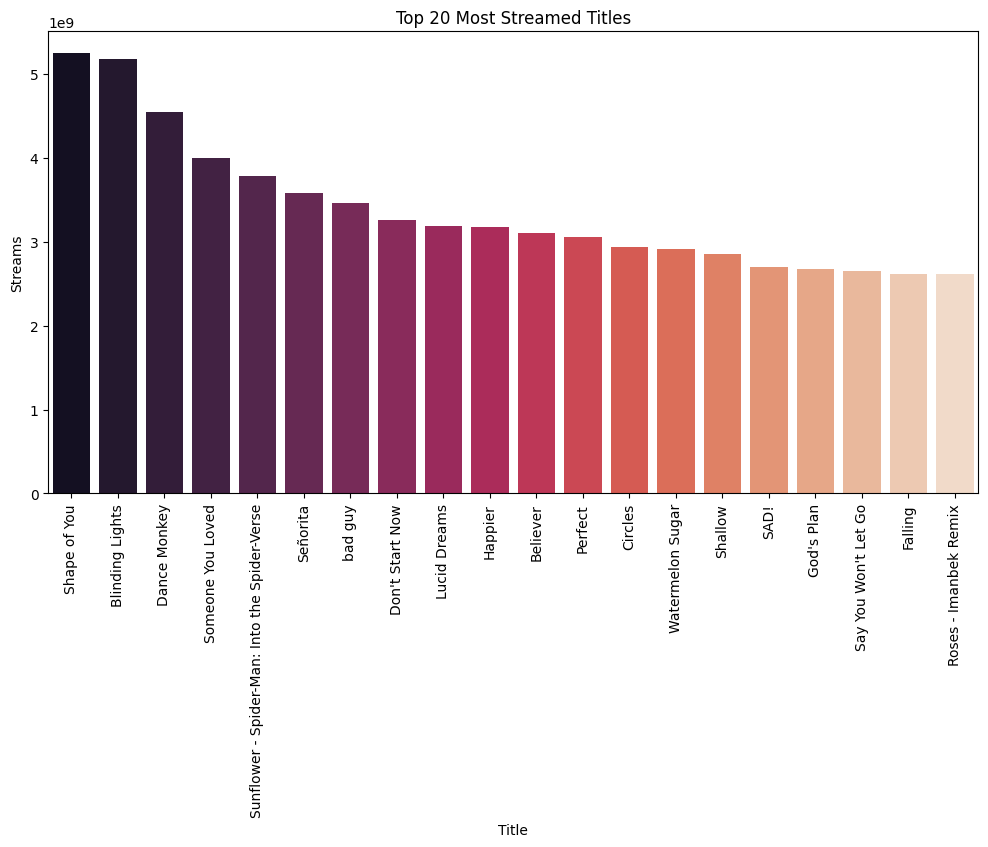

In [7]:
# get total streams for each title
top_streams = df.groupby('title')['streams'].sum()

# sort in descending order
top_streams = top_streams.sort_values(ascending=False)

# take top 20 titles
top_streams = top_streams.head(20)

# create bar plot with seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x=top_streams.index, y=top_streams.values, palette="rocket")
plt.xticks(rotation=90)
plt.xlabel("Title")
plt.ylabel("Streams")
plt.title("Top 20 Most Streamed Titles")
plt.savefig('img/top_20_most_streamed_songs.png')

plt.show()

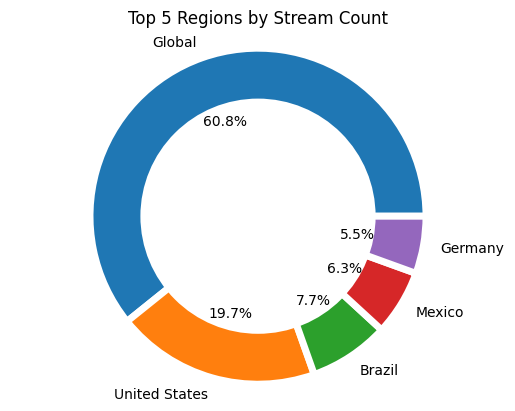

In [8]:
# get total streams by region
total_streams = df.groupby('region')['streams'].sum()

# get top 5 regions by stream count
top_5_regions = total_streams.nlargest(5)

# create donut chart with percentage labels
plt.pie(top_5_regions.values, labels=top_5_regions.index, autopct='%1.1f%%', wedgeprops={'linewidth': 5, 'edgecolor': 'white'})
plt.axis('equal')
plt.title('Top 5 Regions by Stream Count')

# add a white circle in the center to create the hole
center_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.savefig('img/top_5_regions.png')

plt.show()




---


We will attempt to use Spark and SQL to look for trends in the dataset:

We can create DataFrames, register DataFrames as tables, execute SQL over tables, and do much more using a SparkSession.


---



In [9]:
spark = SparkSession.builder \
        .appName("SpotifyCharts") \
        .config("spark.driver.memory", "8g") \
        .getOrCreate()


In [10]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
dfs = spark.createDataFrame(df)

In [11]:
from pyspark.sql.functions import to_date

dfs = dfs.withColumn("date", to_date("date", "yyyy-MM-dd"))

In [12]:
dfs.createOrReplaceTempView("charts")

#Handle Missing Values

In [13]:
dfs = dfs.na.drop(subset=["title", "artist"])


# Get the range of timeline of the data

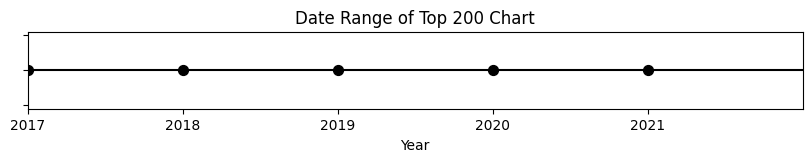

In [15]:
# Execute query and convert result to Pandas DataFrame
date_range_df = spark.sql('''
SELECT MIN(date) begin, MAX(date) end 
FROM charts 
WHERE chart = 'top200';
''').toPandas()

# Extract begin and end dates from DataFrame
begin_date = pd.to_datetime(date_range_df['begin'][0])
end_date = pd.to_datetime(date_range_df['end'][0])

# Calculate date range in years
date_range_years = (end_date - begin_date).days / 365

# Create list of years in date range
years = pd.date_range(begin_date, end_date, freq='YS').tolist()

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(10, 1))
ax.hlines(y=0, xmin=begin_date, xmax=end_date, color='black')
ax.scatter(x=years, y=[0]*len(years), color='black', s=50)
ax.set_xlim([begin_date, end_date])
ax.set_yticklabels([])
ax.set_xlabel('Year')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set title
plt.title('Date Range of Top 200 Chart')

# Save plot to local file
plt.savefig('img/timeline.png')


#View the Head of the Charts

In [16]:
spark.sql('''
SELECT * 
FROM charts 
WHERE chart = 'top200' 
LIMIT 10;
''').toPandas()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0
5,Traicionera,6,2017-01-01,Sebastian Yatra,https://open.spotify.com/track/5J1c3M4EldCfNxX...,Argentina,top200,MOVE_DOWN,151140.0
6,Cuando Se Pone a Bailar,7,2017-01-01,Rombai,https://open.spotify.com/track/1MpKZi1zTXpERKw...,Argentina,top200,MOVE_DOWN,148369.0
7,Otra vez (feat. J Balvin),8,2017-01-01,Zion & Lennox,https://open.spotify.com/track/3QwBODjSEzelZyV...,Argentina,top200,MOVE_DOWN,143004.0
8,La Bicicleta,9,2017-01-01,"Carlos Vives, Shakira",https://open.spotify.com/track/0sXvAOmXgjR2QUq...,Argentina,top200,MOVE_UP,126389.0
9,Dile Que Tu Me Quieres,10,2017-01-01,Ozuna,https://open.spotify.com/track/20ZAJdsKB5IGbGj...,Argentina,top200,MOVE_DOWN,112012.0


# Total Times Songs Ranked in TOP 200 chart

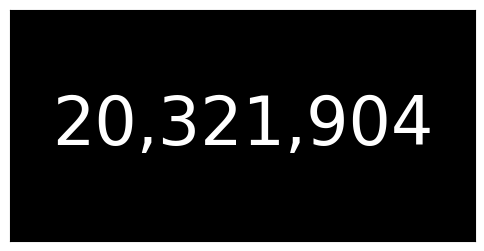

In [17]:
import matplotlib.pyplot as plt

# Execute query and convert result to Pandas DataFrame
no_of_observations_df = spark.sql('''
SELECT COUNT(*) NoOfObservationsTop200
FROM charts 
WHERE chart = 'top200';
''').toPandas()

# Get the count value
count_val = no_of_observations_df['NoOfObservationsTop200'][0]

# Create a figure and axes
fig, ax = plt.subplots(figsize=(6, 3))

# Set the axis background color to black
ax.set_facecolor('black')

# Set the text color to white
text_color = 'white'

# Add the text to the axes
ax.text(0.5, 0.5, f"{count_val:,d}", ha='center', va='center', color=text_color, fontsize=48)

# Remove the axis ticks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

# Save the figure
plt.savefig('img/count_val.png', facecolor='black', bbox_inches='tight')


#Total number of songs by Ed Sheeran & The Weeknd appeared in Top 200

###THE WEEKND

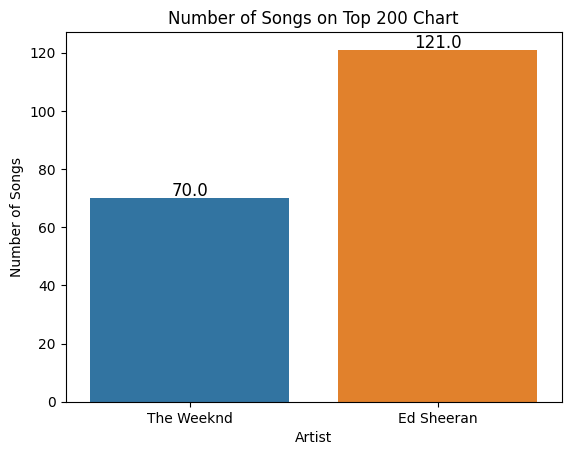

In [18]:
# Execute queries and convert results to Pandas DataFrames
weeknd_df = spark.sql('''
SELECT COUNT(DISTINCT title) NoOfSongs 
FROM charts 
WHERE artist LIKE '%The Weeknd%' AND chart = 'top200';
''').toPandas()

sheeran_df = spark.sql('''
SELECT COUNT(DISTINCT title) NoOfSongs 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' AND chart = 'top200';
''').toPandas()

# Combine DataFrames
combined_df = pd.concat([weeknd_df, sheeran_df], axis=0, ignore_index=True)
combined_df['Artist'] = ['The Weeknd', 'Ed Sheeran']

# Create bar plot
ax = sns.barplot(x='Artist', y='NoOfSongs', data=combined_df)

# Add data labels to each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Set title and axes labels
plt.title('Number of Songs on Top 200 Chart')
plt.xlabel('Artist')
plt.ylabel('Number of Songs')

# Save plot to local file
plt.savefig('img/song_count.png')




---

INSIGHT - Ed's songs were more popular across the world by 1.7X

---



# Number of times Ed Sheeran and The Weeknd appeared in the Top 200 while collaborating with other singers

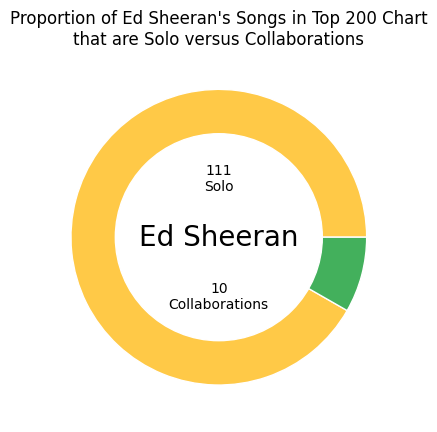

In [19]:
# Execute query and convert result to Pandas DataFrame
sheeran_df = spark.sql('''
SELECT COUNT(DISTINCT title) NoOfSongs 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' AND chart = 'top200';
''').toPandas()

collaborations_df = spark.sql('''
SELECT COUNT(DISTINCT title) NoOfSongs 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' AND chart = 'top200' AND 
      artist != 'Ed Sheeran';
''').toPandas()

# Calculate proportions
total_songs = sheeran_df['NoOfSongs'][0]
collab_songs = collaborations_df['NoOfSongs'][0]
solo_songs = total_songs - collab_songs
collab_prop = collab_songs / total_songs
solo_prop = solo_songs / total_songs

# Create donut chart
fig, ax = plt.subplots()
ax.pie([solo_prop, collab_prop], radius=1, colors=['#FFC947', '#43B05C'],
       wedgeprops=dict(width=0.5, edgecolor='w'))
ax.add_artist(plt.Circle((0,0), 0.7, color='white'))

# Add data labels
ax.text(0, 0, 'Ed Sheeran', ha='center', va='center', fontsize=20)
ax.text(0, 0.4, f'{solo_songs}\nSolo', ha='center', va='center', fontsize=10)
ax.text(0, -0.4, f'{collab_songs}\nCollaborations', ha='center', va='center', fontsize=10)

# Set title
plt.title('Proportion of Ed Sheeran\'s Songs in Top 200 Chart\nthat are Solo versus Collaborations')

# Save plot to local file
plt.savefig('img/ed_sheeran_donut.png')


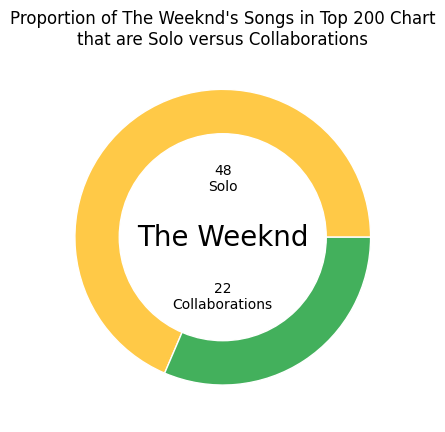

In [20]:
# Execute query and convert result to Pandas DataFrame
weeknd_df = spark.sql('''
SELECT COUNT(DISTINCT title) NoOfSongs 
FROM charts 
WHERE artist LIKE '%The Weeknd%' AND chart = 'top200';
''').toPandas()

collaborations_weeknd_df = spark.sql('''
SELECT COUNT(DISTINCT title) NoOfSongs 
FROM charts 
WHERE artist LIKE '%The Weeknd%' AND chart = 'top200' AND 
      artist != 'The Weeknd';
''').toPandas()

# Calculate proportions
total_songs = weeknd_df['NoOfSongs'][0]
collab_songs = collaborations_weeknd_df['NoOfSongs'][0]
solo_songs = total_songs - collab_songs
collab_prop = collab_songs / total_songs
solo_prop = solo_songs / total_songs


# Create donut chart
fig, ax = plt.subplots()
ax.pie([solo_prop, collab_prop], radius=1, colors=['#FFC947', '#43B05C'],
       wedgeprops=dict(width=0.5, edgecolor='w'))
ax.add_artist(plt.Circle((0,0), 0.7, color='white'))

# Add data labels
ax.text(0, 0, 'The Weeknd', ha='center', va='center', fontsize=20)
ax.text(0, 0.4, f'{solo_songs}\nSolo', ha='center', va='center', fontsize=10)
ax.text(0, -0.4, f'{collab_songs}\nCollaborations', ha='center', va='center', fontsize=10)

# Set title
plt.title('Proportion of The Weeknd\'s Songs in Top 200 Chart\nthat are Solo versus Collaborations')

# Save plot to local file
plt.savefig('img/the_weeknd_donut.png')



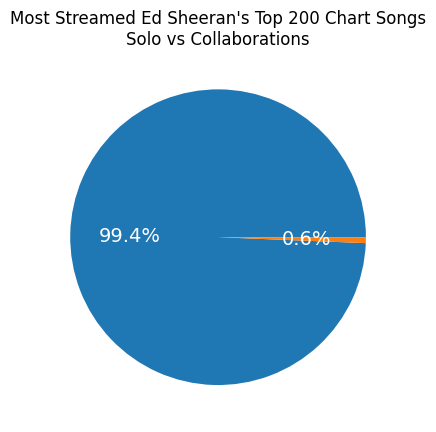

In [21]:
# Execute queries and convert results to Pandas DataFrames
solo_df = spark.sql('''
SELECT COUNT(artist) count 
FROM charts 
WHERE chart = 'top200' AND artist = 'Ed Sheeran'
''').toPandas()

collab_df = spark.sql('''
SELECT COUNT(artist) count 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' AND chart = 'top200' AND artist != 'Ed Sheeran'
''').toPandas()

# Calculate proportions
total_songs = solo_df['count'][0] + collab_df['count'][0]
solo_prop = solo_df['count'][0] / total_songs
collab_prop = collab_df['count'][0] / total_songs

# Create pie chart
fig, ax = plt.subplots()
ax.pie([solo_prop, collab_prop], radius=1, autopct='%1.1f%%')

# Set data labels font size and color
plt.setp(ax.texts, size=14, color='white')

# Set title
plt.title('Most Streamed Ed Sheeran\'s Top 200 Chart Songs\nSolo vs Collaborations')

# Save plot to local file
plt.savefig('img/ed_sheeran_pie.png')


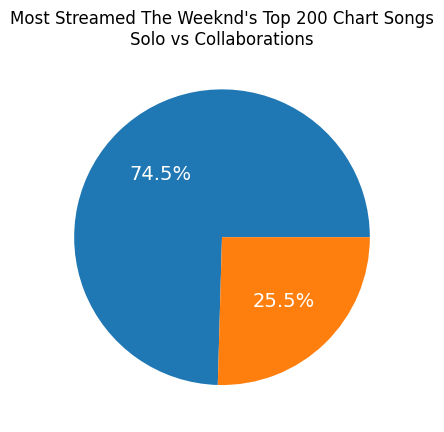

In [22]:
# Execute queries and convert results to Pandas DataFrames
solo_df = spark.sql('''
SELECT COUNT(artist) count 
FROM charts 
WHERE chart = 'top200' AND artist = 'The Weeknd'
''').toPandas()

collab_df = spark.sql('''
SELECT COUNT(artist) count 
FROM charts 
WHERE artist LIKE '%The Weeknd%' AND chart = 'top200' AND artist != 'The Weeknd'
''').toPandas()

# Calculate proportions
total_songs = solo_df['count'][0] + collab_df['count'][0]
solo_prop = solo_df['count'][0] / total_songs
collab_prop = collab_df['count'][0] / total_songs

# Create pie chart
fig, ax = plt.subplots()
ax.pie([solo_prop, collab_prop], radius=1, autopct='%1.1f%%')

# Set data labels font size and color
plt.setp(ax.texts, size=14, color='white')

# Set title
plt.title('Most Streamed The Weeknd\'s Top 200 Chart Songs\nSolo vs Collaborations')

# Save plot to local file
plt.savefig('img/the_weeknd_pie.png')




---

#####INSIGHT - Ed Sheeran did less number of collaborations and his collab songs were not as successful as solos.

In contrast to that, The Weeknd did more collaborations with other singers and his collab songs had more success than Ed's

---



# The top 10 most popular songs of Ed Sheeran and The Weeknd

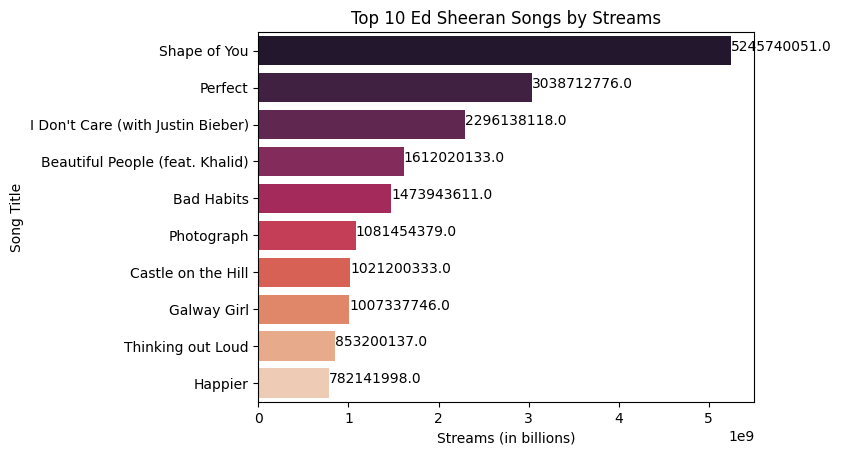

<Figure size 640x480 with 0 Axes>

In [23]:
# execute SQL query and format streams column
query = spark.sql('''
    SELECT title, SUM(streams) streams 
    FROM charts 
    WHERE artist LIKE '%Ed Sheeran%' 
    AND streams IS NOT NULL 
    GROUP BY title 
    ORDER BY streams DESC 
    LIMIT 10;
    ''').toPandas()


# create barplot using seaborn
sns.barplot(data=query, x='streams', y='title', palette='rocket')

# set axis label
plt.xlabel('Streams (in billions)')
plt.ylabel('Song Title')


# set title
plt.title('Top 10 Ed Sheeran Songs by Streams')

# show numbers inside the bars
for index, row in query.iterrows():
    plt.text(row['streams'], index, row['streams'], color='black', ha="left", fontsize=10)

# show plot
plt.show()
plt.savefig('img/top_10_ed.png')

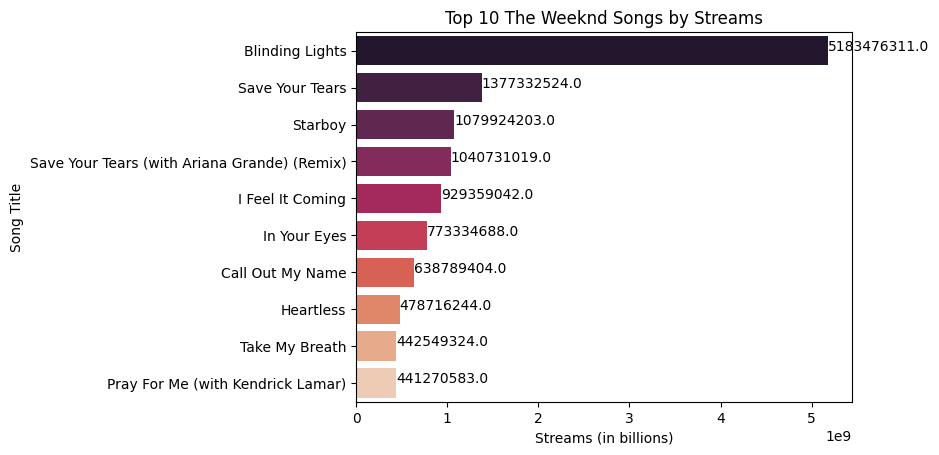

<Figure size 640x480 with 0 Axes>

In [24]:
# execute SQL query and format streams column
query = spark.sql('''
    SELECT title, SUM(streams) streams 
    FROM charts 
    WHERE artist LIKE '%The Weeknd%' 
    AND streams IS NOT NULL 
    GROUP BY title 
    ORDER BY streams DESC 
    LIMIT 10;
    ''').toPandas()


# create barplot using seaborn
sns.barplot(data=query, x='streams', y='title', palette='rocket')

# set axis label
plt.xlabel('Streams (in billions)')
plt.ylabel('Song Title')


# set title
plt.title('Top 10 The Weeknd Songs by Streams')

# show numbers inside the bars
for index, row in query.iterrows():
    plt.text(row['streams'], index, row['streams'], color='black', ha="left", fontsize=10)

# show plot
plt.show()
plt.savefig('img/top_10_weeknd.png')



---

#####INSIGHT - Total Streams of the Top 10 songs of Ed are 1.5X more than The Weeknd's

---



# Number of times top songs of Ed Sheeran & The Weeknd has appeared in top 200

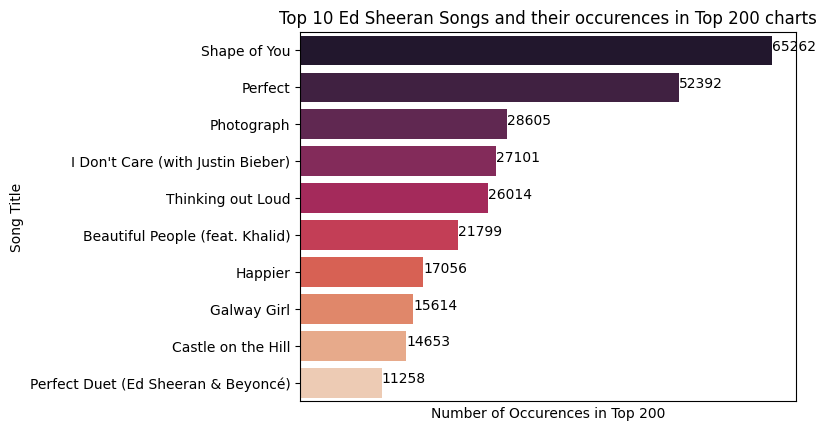

<Figure size 640x480 with 0 Axes>

In [25]:
query= spark.sql('''
    SELECT title, COUNT(title) AS count 
    FROM charts 
    WHERE artist LIKE '%Ed Sheeran%' 
    AND chart = 'top200' 
    GROUP BY title 
    ORDER BY count DESC
    LIMIT 10;
    ''').toPandas()

# create barplot using seaborn
sns.barplot(data=query, x='count', y='title', palette='rocket').set_xticks([])

# set axis label
plt.xlabel('Number of Occurences in Top 200')
plt.ylabel('Song Title')


# set title
plt.title('Top 10 Ed Sheeran Songs and their occurences in Top 200 charts')

# show numbers inside the bars
for index, row in query.iterrows():
    plt.text(row['count'], index, row['count'], color='black', ha="left", fontsize=10)

# show plot
plt.show()
plt.savefig('img/top_10_ed_occur.png')




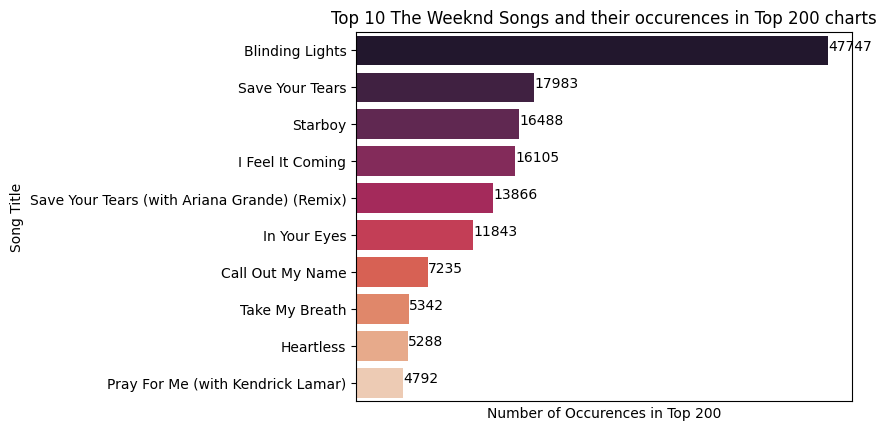

<Figure size 640x480 with 0 Axes>

In [26]:
query= spark.sql('''
    SELECT title, COUNT(title) AS count 
    FROM charts 
    WHERE artist LIKE '%The Weeknd%' 
    AND chart = 'top200' 
    GROUP BY title 
    ORDER BY count DESC
    LIMIT 10;
    ''').toPandas()

# create barplot using seaborn
sns.barplot(data=query, x='count', y='title', palette='rocket').set_xticks([])

# set axis label
plt.xlabel('Number of Occurences in Top 200')
plt.ylabel('Song Title')


# set title
plt.title('Top 10 The Weeknd Songs and their occurences in Top 200 charts')

# show numbers inside the bars
for index, row in query.iterrows():
    plt.text(row['count'], index, row['count'], color='black', ha="left", fontsize=10)

# show plot
plt.show()
plt.savefig('img/top_10_weeknd_occur.png')



# Number of times songs of Ed Sheeran and The Weeknd attaining highest ranks 

In [27]:
spark.sql('''
SELECT title, MIN(rank) rank, COUNT(rank) count 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%'
AND chart = 'top200' 
AND rank = 1 
GROUP BY title
ORDER BY count DESC
LIMIT 20;
''').toPandas()






,title,rank,count
0,Shape of You,1,3840
1,I Don't Care (with Justin Bieber),1,561
2,Bad Habits,1,148
3,Shivers,1,80
4,Galway Girl,1,76
5,Perfect,1,63
6,Perfect Duet (Ed Sheeran & Beyoncé),1,20
7,Beautiful People (feat. Khalid),1,18
8,Castle on the Hill,1,4


In [28]:
spark.sql('''
SELECT title, MIN(rank) rank, COUNT(rank) count 
FROM charts 
WHERE artist LIKE '%The Weeknd%'
AND chart = 'top200' 
AND rank = 1 
GROUP BY title
ORDER BY count DESC
LIMIT 20;
''').toPandas()

,title,rank,count
0,Blinding Lights,1,1365
1,Call Out My Name,1,127
2,Starboy,1,66
3,Save Your Tears,1,49
4,Heartless,1,44
5,After Hours,1,14
6,Lost in the Fire,1,4
7,Take My Breath,1,2
8,Pray For Me (with Kendrick Lamar),1,1




---

#####INSIGHT - Ed's Songs have been popular overall than those of The Weeknd's

---



# Count the number times Ed Sheeran and The Weeknd have been on the 1st rank

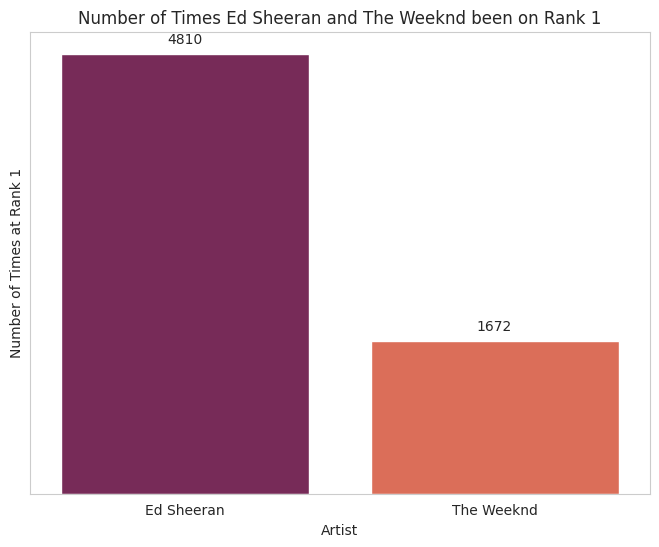

<Figure size 640x480 with 0 Axes>

In [29]:
# Get the number of rank 1 songs for Ed Sheeran
ed_query = spark.sql('''
SELECT COUNT(*) NoOfRank1 
FROM charts 
WHERE artist LIKE '%Ed Sheeran%' 
AND chart = 'top200' 
AND rank = 1;
''').toPandas()

# Get the number of rank 1 songs for The Weeknd
weeknd_query = spark.sql('''
SELECT COUNT(*) NoOfRank1 
FROM charts 
WHERE artist LIKE '%The Weeknd%' 
AND chart = 'top200' 
AND rank = 1;
''').toPandas()

# Combine both dataframes
combined_df = pd.concat([ed_query, weeknd_query], keys=['Ed Sheeran', 'The Weeknd'], names=['Artist'])

# Combine the two dataframes
combined_df = pd.concat([ed_query, weeknd_query], keys=['Ed Sheeran', 'The Weeknd'], names=['Artist'])

# Create the barplot
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(data=combined_df, x=combined_df.index.get_level_values('Artist'), y='NoOfRank1', palette='rocket')

# Add data labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set the title and axis labels
ax.set_title('Number of Times Ed Sheeran and The Weeknd been on Rank 1')
ax.set_xlabel('Artist')
ax.set_ylabel('Number of Times at Rank 1')
ax.set_yticks([])

# Show the plot
plt.show()
plt.savefig('img/times_rank_1.png')




---

#####INSIGHT - Ed Sheeran's Songs have been Ranked 1st for almost 3X more than The Weeknd

---



# Calculate the highest, lowest and the mean rank of the songs of Ed Sheeran and The Weeknd

In [30]:
spark.sql('''
SELECT Title, MIN(rank) Highest, MAX(rank) Lowest, AVG(rank) Avg 
FROM charts 
WHERE artist like '%Ed Sheeran%' 
AND chart='top200' 
GROUP BY title 
ORDER BY Highest;
''').toPandas().head(10)

,Title,Highest,Lowest,Avg
0,Galway Girl,1,200,80.686499
1,Shape of You,1,200,80.527842
2,Perfect Duet (Ed Sheeran & Beyoncé),1,200,101.299698
3,Beautiful People (feat. Khalid),1,200,77.225240
4,I Don't Care (with Justin Bieber),1,200,77.736910
5,Bad Habits,1,200,41.974160
6,Castle on the Hill,1,200,86.030779
7,Perfect,1,200,102.164930
8,Shivers,1,200,41.899490
9,Eraser,2,200,97.767938


In [31]:
spark.sql('''
SELECT Title, MIN(rank) Highest, MAX(rank) Lowest, AVG(rank) Avg 
FROM charts 
WHERE artist like '%The Weeknd%' 
AND chart='top200' 
GROUP BY title 
ORDER BY Highest;
''').toPandas().head(10)

,Title,Highest,Lowest,Avg
0,Starboy,1,200,96.585941
1,Pray For Me (with Kendrick Lamar),1,200,70.306761
2,After Hours,1,200,77.807409
3,Blinding Lights,1,200,43.136427
4,Heartless,1,200,86.981467
5,Save Your Tears,1,200,79.278930
6,Call Out My Name,1,200,83.325363
7,Lost in the Fire,1,200,74.014967
8,Take My Breath,1,200,70.090603
9,I Feel It Coming,2,200,83.712574




---


##### INSIGHT - Both Ed Sheeran and The Weeknd have almost equal number of songs that are well liked all over the world


---









# Show the trends of top songs of Ed Sheeran and The Weeknd over time

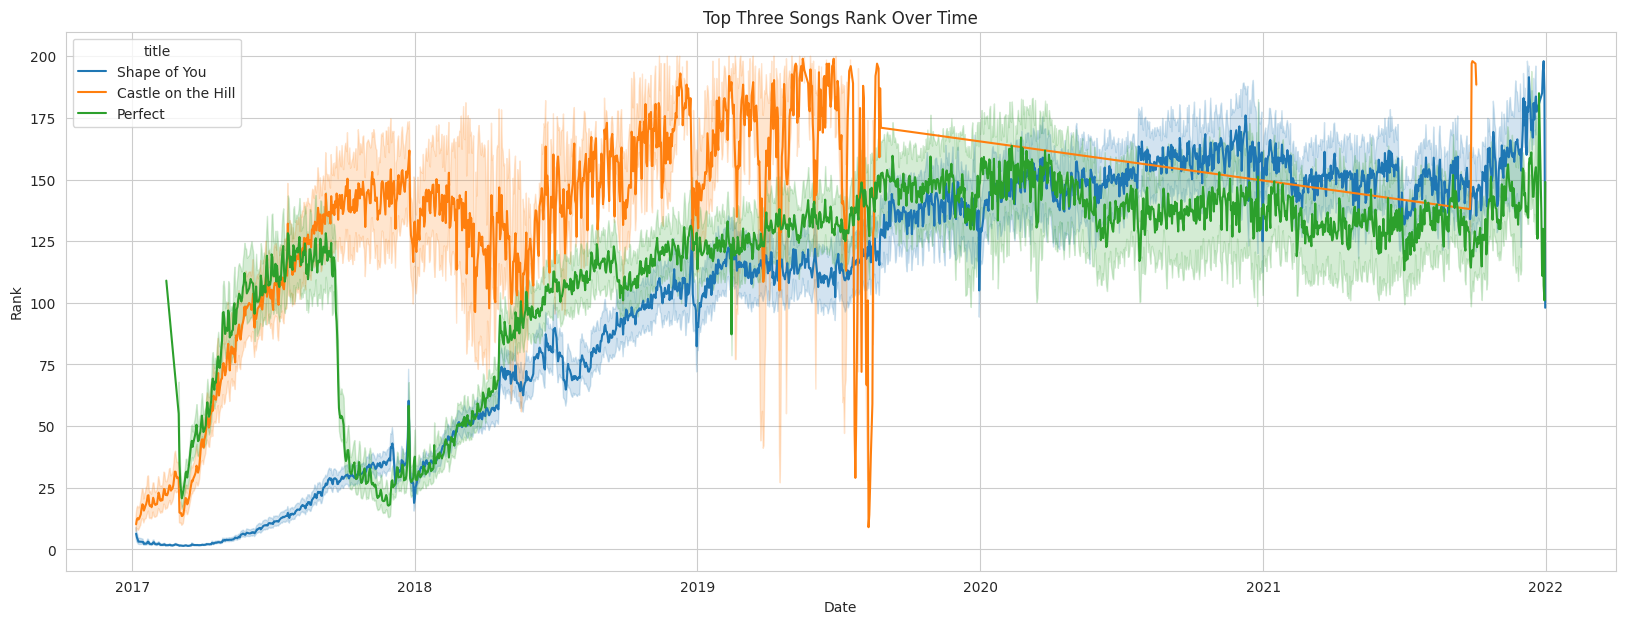

In [32]:
q = spark.sql('''
SELECT title, YEAR(date) year, date, rank, region 
FROM charts 
WHERE title IN ('Shape of You','Castle on the Hill','Perfect') 
AND chart='top200'
ORDER BY rank ASC;''').toPandas()

fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(x='date', y='rank', hue='title', data=q)
plt.title('Top Three Songs Rank Over Time')
plt.xlabel('Date')
plt.ylabel('Rank')
plt.savefig('img/trend_ed.png')

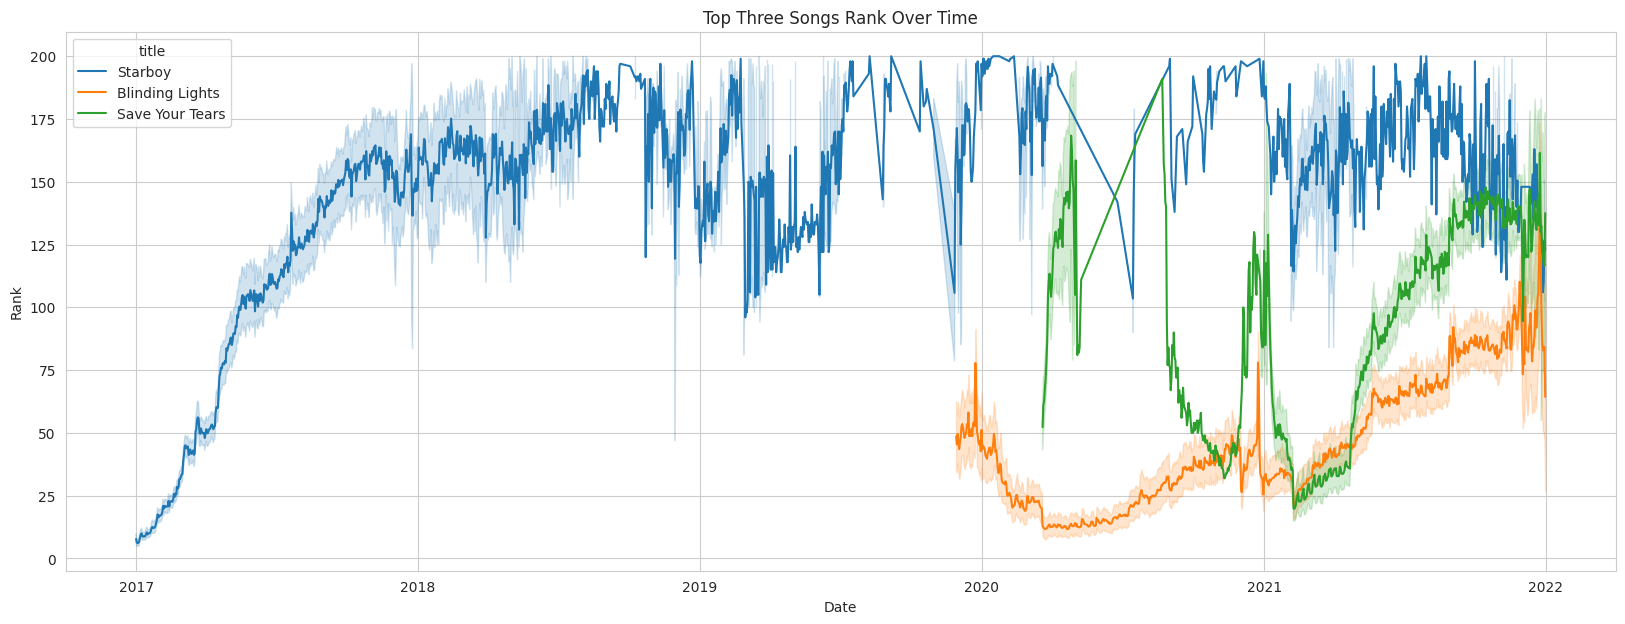

In [33]:
p = spark.sql('''
SELECT title, YEAR(date) year, date, rank, region 
FROM charts 
WHERE title IN ('Blinding Lights','Save Your Tears','Starboy') 
AND chart='top200'
ORDER BY rank ASC;''').toPandas()

fig, axes = plt.subplots(figsize=(20,7))
sns.lineplot(x='date', y='rank', hue='title', data=p)
plt.title('Top Three Songs Rank Over Time')
plt.xlabel('Date')
plt.ylabel('Rank')
plt.savefig('img/trend_weeknd.png')



---


#####INSIGHT - Ed Sheeran's Songs were more popular before 2020 and whereas The Weeknd's songs gained popularity after 2020 and stayed in the top ranked for longer time than Ed Sheeran's


---



In [35]:
bucket_name = 'dsa-final-project'
folder_path = 'img/'

# Walk through the local directory and upload files to S3
for root, dirs, files in os.walk('img'):
    for file in files:
        local_path = os.path.join(root, file)
        s3_path = os.path.join(folder_path, file)
        s3.upload_file(local_path, bucket_name, s3_path)

#Recommendations

## For Ed Sheeran:



1.   ***Leverage his success with solo songs:*** Since Ed's solo songs have been more popular than his collab songs, he should focus on releasing more solo songs that showcase his unique style and voice. He should also experiment with different genres and styles to keep his music fresh and interesting for his fans.

2.   ***Collaborate wisely:*** Although Ed's collab songs were not as successful as his solos, he should still consider collaborating with other artists to expand his audience and reach new fans. However, he should be selective in choosing his collaborators to ensure that the songs have the potential for success and align with his brand and style.

3. ***Maintain global appeal:*** Ed's music has been well received globally, and he should continue to create music that resonates with a global audience. He should also consider promoting his music on social media platforms, which can help him to reach a younger and broader audience.

4. ***Leverage his existing success:*** Ed should leverage his existing success by continuing to perform live shows and concerts. He could also consider collaborating with other artists during these shows to keep things fresh and exciting for his fans.

## For The Weeknd:

1. ***Continue collaborating with other artists:*** Since The Weeknd's collab songs have been more successful than his solo songs, he should continue to collaborate with other artists. He should also be selective in choosing his collaborators to ensure that the songs have the potential for success and align with his brand and style.

2. ***Experiment with different genres:*** The Weeknd has already shown his ability to experiment with different genres, and he should continue to do so to keep his music fresh and interesting for his fans. He should also consider collaborating with artists from different genres to explore new sounds and styles.

3. ***Focus on promoting his music online:*** The Weeknd's music has gained popularity after 2020, and he should focus on promoting his music online to continue building his fan base. He should consider partnering with social media influencers to reach new audiences and use data-driven marketing strategies to reach the right people.

4. ***Leverage his success to perform live shows:*** The Weeknd should leverage his existing success to perform live shows and concerts. He could also consider collaborating with other artists during these shows to keep things fresh and exciting for his fans.